In [38]:
import sys
# Add the 'site-packages' directory, NOT the specific .py file
# sys.path.append("/Users/markzhitnitsky/opt/anaconda3/lib/python3.9/site-packages")
import astra
import numpy as np
import matplotlib.pyplot as plt
import Methods as m
import importlib
importlib.reload(m)


<module 'Methods' from '/Users/markzhitnitsky/Desktop/School/2025-26 Year/PHYS409/Experiment 1 - PET/Code/Methods.py'>

In [39]:
def reconstruct_astra(data_array, v_geom, p_geom):
    # Ensure data is 32-bit for C++ backend
    data_array = np.ascontiguousarray(data_array, dtype=np.float32)

    sinogram_id = astra.data2d.create('-sino', p_geom, data_array)
    reconstruction_id = astra.data2d.create('-vol', v_geom)

    # 1. Create a Projector for CPU FBP
    projector_id = astra.create_projector('line', p_geom, v_geom)

    # 2. Setup the Algorithm
    cfg = astra.astra_dict('FBP')
    cfg['ReconstructionDataId'] = reconstruction_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = projector_id  # <--- This fixes the error
    cfg['FilterType'] = 'cosine'

    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)

    res = astra.data2d.get(reconstruction_id)

    # 3. Cleanup everything
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(reconstruction_id)
    astra.data2d.delete(sinogram_id)
    astra.projector.delete(projector_id)

    return res

In [40]:
directory = "./data/Measurement Run 5 2026-01-16"
countArr, uCountArr, distance, angles = m.readSinogram(directory)
# print(distance)
angles = angles - 90
# m.display_raw_sinogram(countArr, distance, angles, "measurement 5 sinogram")
# print(countArr.shape)
# recon = iradon(countArr, theta=angles, output_size=int(len(distance) * np.sqrt(2)), filter_name="cosine", circle=False)

In [41]:

# 1. Setup Geometry
# num_detectors = countArr.shape[0] # s-axis
num_angles = countArr.shape[1]    # theta-axis
# detector_spacing = distance[1] - distance[0]
angles_rad = np.deg2rad(angles)

# Create volume and projection geometries
# Calculate the physical width of your detector array
num_detectors = countArr.shape[0]
detector_spacing = distance[1] - distance[0]
total_width = num_detectors * detector_spacing

# Define the boundaries so the reconstruction 'box' matches the detector span
half_width = (len(distance) * detector_spacing * np.sqrt(2)) / 2

# create_vol_geom(rows, cols, min_x, max_x, min_y, max_y)
vol_geom = astra.create_vol_geom(
    num_detectors,
    num_detectors,
    -half_width, half_width,
    -half_width, half_width
)
# vol_geom = astra.create_vol_geom(num_detectors, num_detectors)
proj_geom = astra.create_proj_geom('parallel', detector_spacing, num_detectors, angles_rad)


# 2. Reconstruct the Image
recon = reconstruct_astra(countArr.T, vol_geom, proj_geom)

# Do the same for the uncertainty calculation
variance_sinogram = (uCountArr**2).T
recon_variance = reconstruct_astra(variance_sinogram, vol_geom, proj_geom)

# Ensure no negative variances from filter artifacts before sqrt
recon_uncertainty = np.sqrt(np.abs(recon_variance))
scalingFactor = sum(sum(countArr)) / sum(sum(recon))
# dimx, dimy = recon.size
# distanceRecon = np.arange(-half_width,half_width, detector_spacing)
distanceRecon = np.linspace(-half_width, half_width, recon.shape[0])

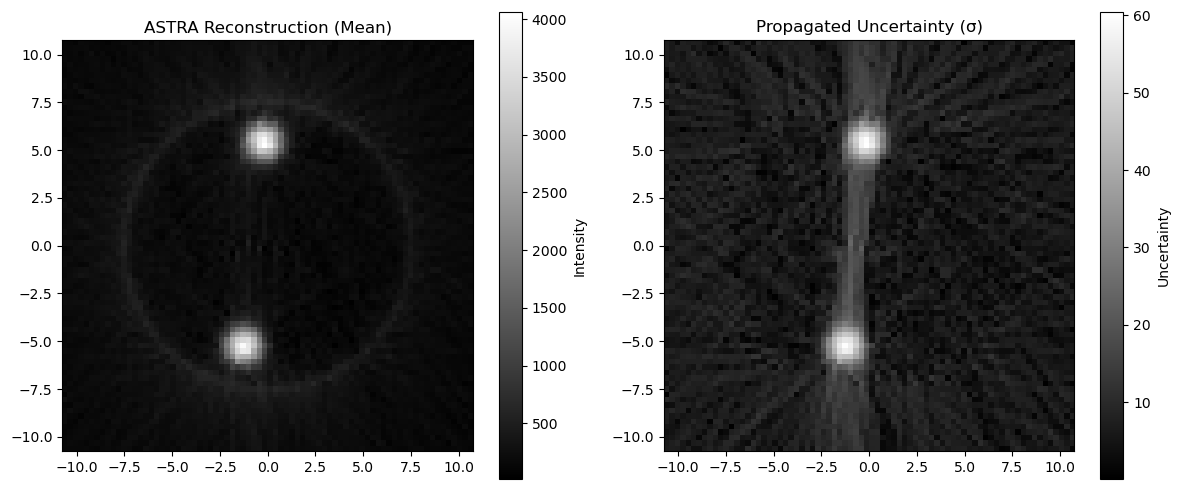

In [42]:
# 1. Clean up the data
# Transpose to match standard viewing and clip negative noise
plot_recon = np.flipud(recon.T) * scalingFactor
plot_unc = np.flipud(recon_uncertainty.T) * scalingFactor

# Clip negatives
plot_recon[plot_recon < 0] = 0

# 2. Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Reconstruction
im0 = ax[0].imshow(plot_recon, extent=[
        distanceRecon[0], distanceRecon[-1],
        distanceRecon[0], distanceRecon[-1]],
               cmap="gray",origin='lower')
ax[0].set_title("ASTRA Reconstruction (Mean)")
fig.colorbar(im0, ax=ax[0], label='Intensity')

# Plot Uncertainty Map
im1 = ax[1].imshow(plot_unc, extent=[
        distanceRecon[0], distanceRecon[-1],
        distanceRecon[0], distanceRecon[-1]],
               cmap="gray",origin='lower')
ax[1].set_title("Propagated Uncertainty (σ)")
fig.colorbar(im1, ax=ax[1], label='Uncertainty')

plt.tight_layout()
plt.show()